In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math
import time

In [2]:
df = pd.read_csv('../../data/loureiro_45houses.csv')
df

,Time,Energy_1,Energy_2,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_29,Energy_30,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.114,0.164,0.072,0.055,0.011,0.006,...,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004,0.008
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.190,0.135,0.058,0.060,0.002,0.006,...,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003,0.056
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.180,0.121,0.011,0.096,0.010,0.006,...,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004,0.033
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.167,0.138,0.010,0.064,0.004,0.006,...,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004,0.062
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.133,0.104,0.011,0.072,0.002,0.006,...,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38012,2023-06-05 11:00:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38013,2023-06-05 11:15:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38014,2023-06-05 11:30:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028


In [3]:
df_location = pd.read_csv("../../data/loureiro_45houses_location.csv")
df_location

,Time,Energy,Location
0,2022-05-05 12:00:00,0.068,Energy_1
1,2022-05-05 12:15:00,0.070,Energy_1
2,2022-05-05 12:30:00,0.122,Energy_1
3,2022-05-05 12:45:00,0.132,Energy_1
4,2022-05-05 13:00:00,0.125,Energy_1
...,...,...,...
1710715,2023-06-05 10:45:00,0.028,Energy_172
1710716,2023-06-05 11:00:00,0.028,Energy_172
1710717,2023-06-05 11:15:00,0.028,Energy_172
1710718,2023-06-05 11:30:00,0.028,Energy_172


In [4]:
num_samples_per_house = df_location.Location.value_counts()[0]
num_houses = df_location.Location.nunique()
num_samples_per_house, num_houses

(38016, 45)

In [5]:
def no_ml_predict(X: np.array, y: np.array):
    rmse = truncate_metric(mean_squared_error(X, y, squared=False))
    #wape = mean_absolute_error(X,y) / y.mean()
    wape = truncate_metric(float(np.sum(np.abs(X - y)) / np.sum(np.abs(y))))
    r2 = truncate_metric(r2_score(X, y))
    
    print('RMSE: %.4f' % rmse)
    print('WAPE: %.2f' % (wape * 100))
    print('R2: %.4f' % r2)
    return rmse, wape, r2


def truncate_metric(metric):
    m = math.trunc(10000*metric) / 10000
    return m

def truncate(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = df.applymap(trunc)
    return df_trunc

def truncate_location(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
    df = pd.concat([df.iloc[:,0:-1], df_trunc],axis=1)
    return df
    
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
def total_averaged_metrics(metrics_list):
    rmse = np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)
    wape = np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)
    r2 = np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)
    print("Total Averaged RMSE: {}".format(rmse))
    print("Total Averaged WAPE: {}".format(wape * 100))
    print("Total Averaged R2: {}".format(r2))
    return rmse, wape, r2

In [6]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [7]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
38011,4.150
38012,4.149
38013,4.150
38014,4.179


## Individual 51 houses preprocessing
### Previous 15 minutes

In [8]:
X15 = df_location.copy()
for i in range(1, num_houses):
    X15.iloc[(num_samples_per_house*i)-1] = np.nan
X15.dropna(inplace=True)
m = len(X15)
X15 = X15.iloc[0:(m-1)]
X15.drop(["Time", "Location"],inplace=True, axis=1)
X15.reset_index(drop=True, inplace=True)
X15

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1710670,0.028
1710671,0.028
1710672,0.028
1710673,0.028


In [9]:
y15 = df_location.copy()
for i in range(1, num_houses):
    y15.iloc[(num_samples_per_house*i)] = np.nan
y15.dropna(inplace=True)
y15 = y15.iloc[1:].reset_index(drop=True)
y15.drop(["Time", "Location"],inplace=True, axis=1)
y15.reset_index(drop=True, inplace=True)
y15

,Energy
0,0.070
1,0.122
2,0.132
3,0.125
4,0.089
...,...
1710670,0.028
1710671,0.028
1710672,0.028
1710673,0.028


### Previous day at same hour

In [10]:
Xday = df_location.copy()
for i in range(1, num_houses):
    Xday.iloc[(num_samples_per_house*i)-1] = np.nan
Xday.dropna(inplace=True)
m = len(Xday)
Xday = Xday.iloc[0:(m-96)]
Xday.drop(["Time", "Location"],inplace=True, axis=1)
Xday.reset_index(drop=True, inplace=True)
Xday

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1710575,0.035
1710576,0.011
1710577,0.054
1710578,0.035


In [11]:
yday = df_location.copy()
for i in range(1, num_houses):
    yday.iloc[(num_samples_per_house*i)] = np.nan
yday.dropna(inplace=True)
yday = yday.iloc[96:].reset_index(drop=True)
yday.drop(["Time", "Location"],inplace=True, axis=1)
yday.reset_index(drop=True, inplace=True)
yday

,Energy
0,0.057
1,0.065
2,0.030
3,0.329
4,0.329
...,...
1710575,0.028
1710576,0.028
1710577,0.028
1710578,0.028


### Previous week same day and same hour

In [12]:
Xweek = df_location.copy()
for i in range(1, num_houses):
    Xweek.iloc[(num_samples_per_house*i)-1] = np.nan
Xweek.dropna(inplace=True)
m = len(Xweek)
Xweek = Xweek.iloc[0:(m-672)]
Xweek.drop(["Time", "Location"],inplace=True, axis=1)
Xweek.reset_index(drop=True, inplace=True)
Xweek

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1709999,0.027
1710000,0.041
1710001,0.019
1710002,0.058


In [13]:
yweek = df_location.copy()
for i in range(1, num_houses):
    yweek.iloc[(num_samples_per_house*i)] = np.nan
yweek.dropna(inplace=True)
yweek = yweek.iloc[672:].reset_index(drop=True)
yweek.drop(["Time", "Location"],inplace=True, axis=1)
yweek.reset_index(drop=True, inplace=True)
yweek

,Energy
0,0.039
1,0.061
2,0.038
3,0.069
4,0.063
...,...
1709999,0.028
1710000,0.028
1710001,0.028
1710002,0.028


## Prediction organized by location
### Previous 15 minutes

In [14]:
X15_norm, scaler = normalize_training(X15)
y15_norm = scaler.transform(y15)
X15_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.01320755],
       [0.01320755],
       [0.01320755]])

In [15]:
rmse_15_norm, wape_15_norm, r2_15_norm = no_ml_predict(X15_norm, y15_norm)

RMSE: 0.0366
WAPE: 36.43
R2: 0.6384


In [16]:
rmse_15, wape_15, r2_15 = no_ml_predict(X15, y15)

RMSE: 0.0777
WAPE: 36.43
R2: 0.6384


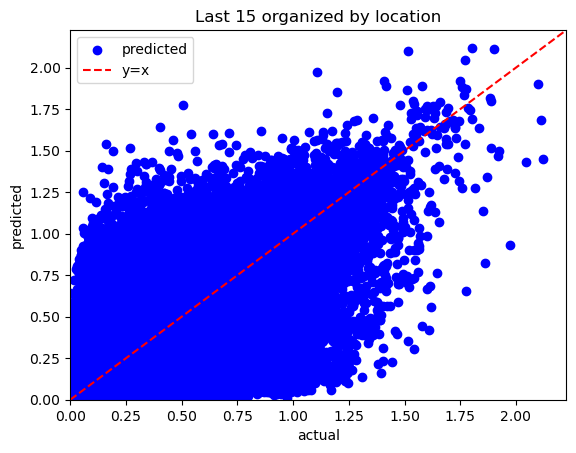

In [17]:
plot_results(X15, y15, "Last 15 organized by location")

### Previous day at same hour

In [18]:
Xday_norm, scaler = normalize_training(Xday)
yday_norm = scaler.transform(yday)
Xday_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.0254717 ],
       [0.01650943],
       [0.04481132]])

In [19]:
rmse_day_norm, wape_day_norm, r2_day_norm = no_ml_predict(Xday_norm, yday_norm)

RMSE: 0.0612
WAPE: 66.70
R2: -0.0109


In [20]:
rmse_day, wape_day, r2_day = no_ml_predict(Xday, yday)

RMSE: 0.1299
WAPE: 66.70
R2: -0.0109


/home/francisco.monteiro@av.it.pt/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


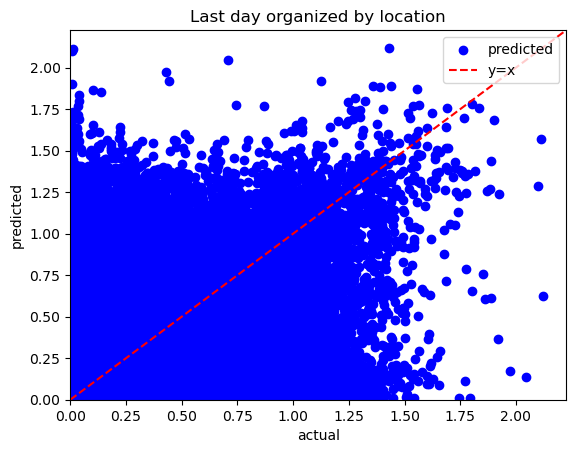

In [21]:
plot_results(Xday, yday, "Last day organized by location")

### Previous week same day and same hour

In [22]:
Xweek_norm, scaler = normalize_training(Xweek)
yweek_norm = scaler.transform(yweek)
Xweek_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.00896226],
       [0.02735849],
       [0.21556604]])

In [23]:
rmse_week_norm, wape_week_norm, r2_week_norm = no_ml_predict(Xweek_norm, yweek_norm)

RMSE: 0.0619
WAPE: 66.99
R2: -0.0323


In [24]:
rmse_week, wape_week, r2_week = no_ml_predict(Xweek, yweek)

RMSE: 0.1313
WAPE: 66.99
R2: -0.0323


/home/francisco.monteiro@av.it.pt/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


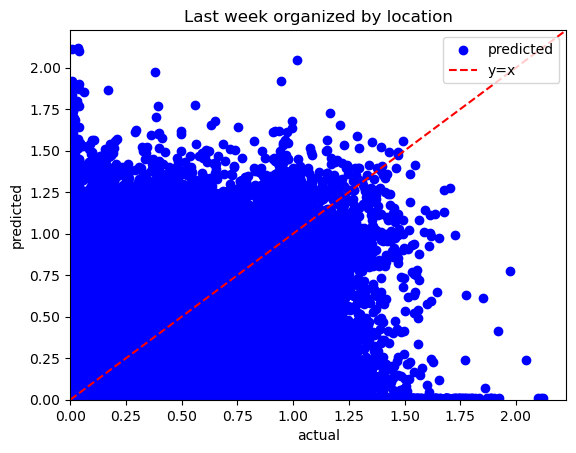

In [25]:
plot_results(Xweek, yweek, "Last week organized by location")

# Sum of all houses preprocessing
### Previous 15 minutes prediction data

In [26]:
X_total_15 = df_total.copy()
m = len(X_total_15)
X_total_15 = X_total_15.iloc[0:(m-1)]
X_total_15

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
38010,4.149
38011,4.150
38012,4.149
38013,4.150


In [27]:
y_total_15 = df_total.copy()
y_total_15 = y_total_15.iloc[1:].reset_index(drop=True)
y_total_15

,Energy
0,3.043
1,2.959
2,3.067
3,2.987
4,3.755
...,...
38010,4.150
38011,4.149
38012,4.150
38013,4.179


In [28]:
X_total_15_norm, scaler = normalize_training(X_total_15)
y_total_15_norm = scaler.transform(y_total_15)

### Previous day at same hour prediction data

In [29]:
X_total_prev_day = df_total.copy()
m = len(X_total_prev_day)
X_total_prev_day = X_total_prev_day.iloc[0:(m-96)]
X_total_prev_day

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
37915,4.978
37916,4.354
37917,5.659
37918,4.887


In [30]:
y_total_prev_day = df_total.copy()
y_total_prev_day = y_total_prev_day.iloc[96:].reset_index(drop=True)
y_total_prev_day[:15]

,Energy
0,2.863
1,3.503
2,4.067
3,3.941
4,4.148
5,4.086
6,3.513
7,4.229
8,3.787
9,3.922


In [31]:
X_total_prev_day_norm, scaler = normalize_training(X_total_prev_day)
y_total_prev_day_norm = scaler.transform(y_total_prev_day)

### Previous week same day at same hour prediction data

In [32]:
X_total_prev_week = df_total.copy()
m = len(X_total_prev_week)
X_total_prev_week = X_total_prev_week.iloc[0:(m-96*7)]
X_total_prev_week

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
37339,3.270
37340,3.091
37341,3.443
37342,3.273


In [33]:
y_total_prev_week = df_total.copy()
y_total_prev_week = y_total_prev_week.iloc[(96*7):].reset_index(drop=True)
y_total_prev_week

,Energy
0,2.705
1,3.800
2,3.265
3,2.679
4,2.949
...,...
37339,4.150
37340,4.149
37341,4.150
37342,4.179


In [34]:
X_total_prev_week_norm, scaler = normalize_training(X_total_prev_week)
y_total_prev_week_norm = scaler.transform(y_total_prev_week)

## Prediction (sum of all houses)

#### R2 will be negative whenever your model's predictions are worse than a constant function that always predicts the mean of the data.

### Previous 15 minutes prediction data

In [35]:
rmse_total_15_norm, wape_total_15_norm, r2_total_15_norm = no_ml_predict(X_total_15_norm, y_total_15_norm)

RMSE: 0.0391
WAPE: 10.48
R2: 0.8542


In [36]:
rmse_total_15, wape_total_15, r2_total_15 = no_ml_predict(X_total_15, y_total_15)

RMSE: 0.5377
WAPE: 10.48
R2: 0.8542


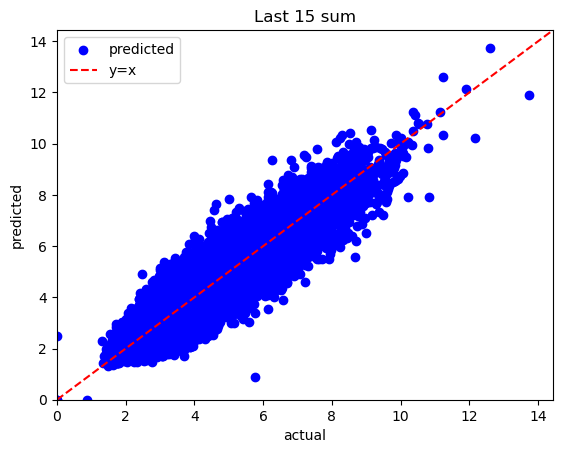

In [37]:
plot_results(X_total_15, y_total_15, "Last 15 sum")

### Previous day at same hour prediction data

In [38]:
rmse_total_prev_day_norm, wape_total_prev_day_norm, r2_total_prev_day_norm = no_ml_predict(X_total_prev_day_norm, y_total_prev_day_norm)

RMSE: 0.0684
WAPE: 18.29
R2: 0.5550


In [39]:
rmse_total_prev_day, wape_total_prev_day, r2_total_prev_day = no_ml_predict(X_total_prev_day, y_total_prev_day)

RMSE: 0.9404
WAPE: 18.29
R2: 0.5550


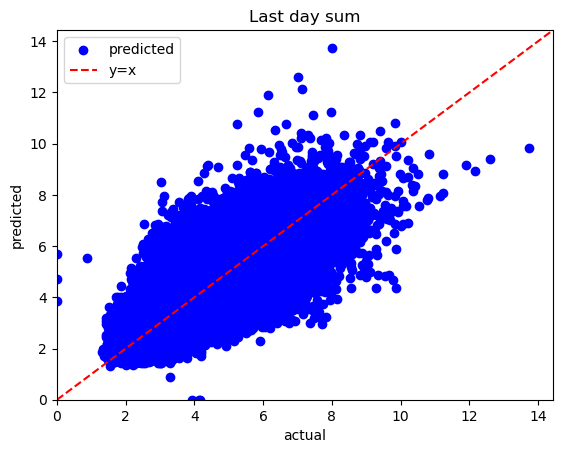

In [40]:
plot_results(X_total_prev_day, y_total_prev_day, "Last day sum")

### Previous week same day at same hour prediction data

In [41]:
rmse_total_prev_week_norm, wape_total_prev_week_norm, r2_total_prev_week_norm = no_ml_predict(X_total_prev_week_norm, y_total_prev_week_norm)

RMSE: 0.0683
WAPE: 18.18
R2: 0.5586


In [42]:
rmse_total_prev_week, wape_total_prev_week, r2_total_prev_week = no_ml_predict(X_total_prev_week, y_total_prev_week)

RMSE: 0.9393
WAPE: 18.18
R2: 0.5586


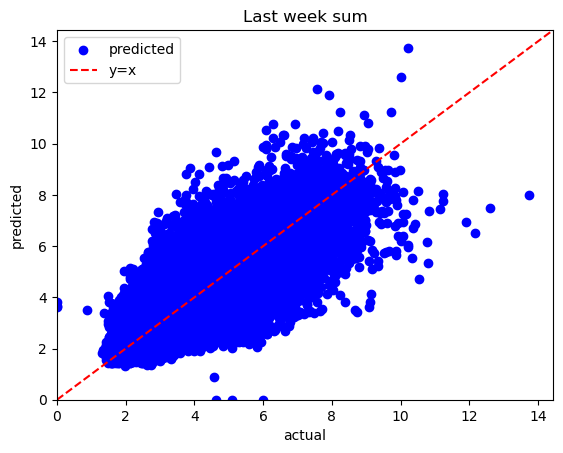

In [43]:
plot_results(X_total_prev_week, y_total_prev_week, "Last week sum")

## Comparison between individual and sum

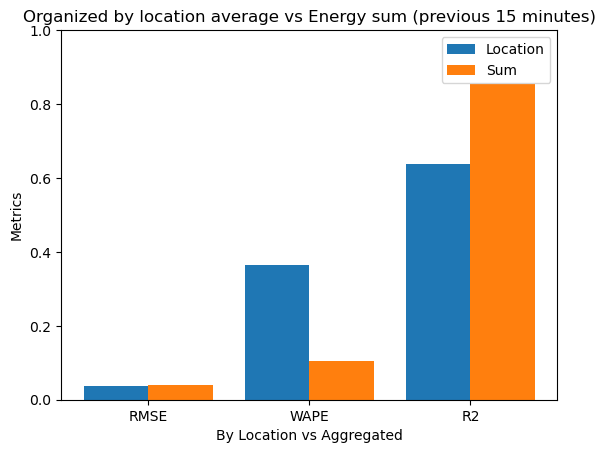

In [44]:
X_names = ("RMSE", "WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (rmse_15_norm, wape_15, r2_15), 0.4, label = 'Location')
plt.bar(X_axis + 0.2, (rmse_total_15_norm, wape_total_15, r2_total_15), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("By Location vs Aggregated")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Organized by location average vs Energy sum (previous 15 minutes)")
plt.legend()
plt.show()

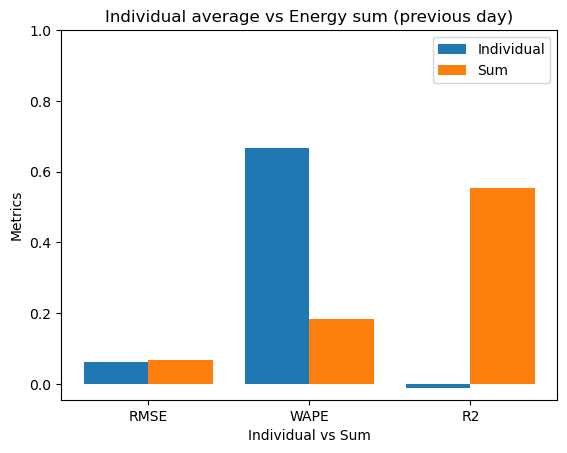

In [45]:
plt.bar(X_axis - 0.2, (rmse_day_norm, wape_day, r2_day), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (rmse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous day)")
plt.legend()
plt.show()

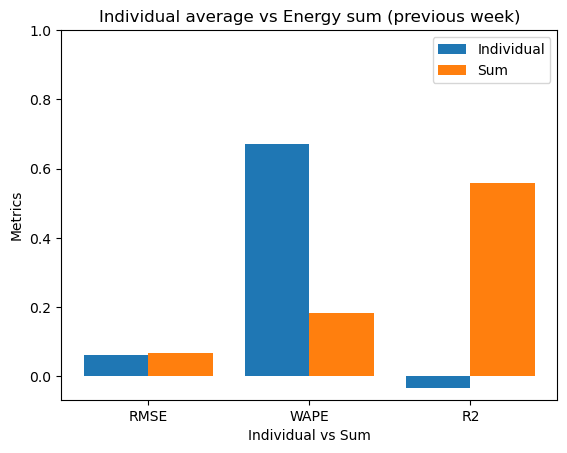

In [46]:
plt.bar(X_axis - 0.2, (rmse_week_norm, wape_week, r2_week), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (rmse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous week)")
plt.legend()
plt.show()

In [47]:
names_alg = ["Baseline - Previous 15\n", "Baseline - Previous Day\n", "Baseline - Previous Week\n"]
all_metrics = [(rmse_15, wape_15, r2_15), (rmse_day, wape_day, r2_day), (rmse_week, wape_week, r2_week)]
all_metrics_agg = [(rmse_total_15_norm, wape_total_15, r2_total_15), (rmse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), (rmse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week)]

In [48]:
with open('../../gpu_logs/no_ml_loureiro.txt', 'w') as file:
    for i in range(0, 3):
        file.write(names_alg[i])
        file.write("Baseline\n")
        rmse_msg = "RMSE: " + str(all_metrics[i][0]) + "\n"
        wape_msg = "WAPE: " + str(all_metrics[i][1]) + "\n"
        r2_msg = "R2: " + str(all_metrics[i][2]) + "\n"
        file.write(rmse_msg)
        file.write(wape_msg)
        file.write(r2_msg)
        file.write("Baseline_Aggregated\n")
        rmse_msg_agg = "RMSE: " + str(all_metrics_agg[i][0]) + "\n"
        wape_msg_agg = "WAPE: " + str(all_metrics_agg[i][1]) + "\n"
        r2_msg_agg = "R2: " + str(all_metrics_agg[i][2]) + "\n"
        file.write(rmse_msg_agg)
        file.write(wape_msg_agg)
        file.write(r2_msg_agg)